<a href="https://colab.research.google.com/github/pedrosena138/if1014-data-mining/blob/main/Default_of_Credit_Card_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Set Information





This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel â€œSorting Smoothing Methodâ€ to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default.

## Attribute Information

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
- X6 = the repayment status in September, 2005; 
- X7 = the repayment status in August, 2005; . . .;
- X11 = the repayment status in April, 2005. 

The measurement scale for the repayment status is: 
- -1 = pay duly; 
- 1 = payment delay for one month; 
- 2 = payment delay for two months; . . .;
- 8 = payment delay for eight months; 
- 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). 
- X12 = amount of bill statement in September, 2005; 
- X13 = amount of bill statement in August, 2005; . . .; 
- X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). 
- X18 = amount paid in September, 2005; 
- X19 = amount paid in August, 2005; . . .;
- X23 = amount paid in April, 2005.

Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

# Libs

In [61]:
import os
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import scipy
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler

mpl.rcParams['figure.figsize'] = (24, 14)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

seed_value= 12321 

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# Exploratory Analysis

In [32]:
dataset = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls')
dataset.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [33]:
dataset_labels_dict = {}
dataset.rename({'Unnamed: 0': 'ID'}, axis=1, inplace=True)
columns = list(dataset.columns)
values = list(dataset.iloc[0])

columns.pop(0)
values.pop(0)

for i in range(len(values)):
    dataset_labels_dict[columns[i]] = values[i]

dataset.drop([0], inplace=True)
dataset_labels_dict

{'X1': 'LIMIT_BAL',
 'X2': 'SEX',
 'X3': 'EDUCATION',
 'X4': 'MARRIAGE',
 'X5': 'AGE',
 'X6': 'PAY_0',
 'X7': 'PAY_2',
 'X8': 'PAY_3',
 'X9': 'PAY_4',
 'X10': 'PAY_5',
 'X11': 'PAY_6',
 'X12': 'BILL_AMT1',
 'X13': 'BILL_AMT2',
 'X14': 'BILL_AMT3',
 'X15': 'BILL_AMT4',
 'X16': 'BILL_AMT5',
 'X17': 'BILL_AMT6',
 'X18': 'PAY_AMT1',
 'X19': 'PAY_AMT2',
 'X20': 'PAY_AMT3',
 'X21': 'PAY_AMT4',
 'X22': 'PAY_AMT5',
 'X23': 'PAY_AMT6',
 'Y': 'default payment next month'}

In [34]:
type_dict = {}
for i in range(12, 24):
    type_dict[f'X{i}'] = np.float32

for i in range(2, 12):
    type_dict[f'X{i}'] = 'category'

type_dict['X1'] = np.float32
type_dict['X5'] = 'int8'
type_dict['ID'] = 'category'
type_dict['Y'] = 'category'

dataset = dataset.astype(type_dict)

dataset.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
1,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Checagem de valores ausentes

In [6]:
dataset.isnull().sum()

ID     0
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

In [35]:
dataset.describe()

,X1,X5,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.328125,35.485500,51223.335938,49179.078125,4.701315e+04,43262.949219,40311.398438,38871.761719,5663.580566,5.921164e+03,5225.681641,4826.076660,4799.387695,5215.502441
std,129743.382812,9.217904,73635.773438,71173.195312,6.934824e+04,64332.000000,60797.367188,59553.609375,16563.017578,2.304034e+04,17606.562500,15665.456055,15278.589844,17777.894531
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.000000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.000000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


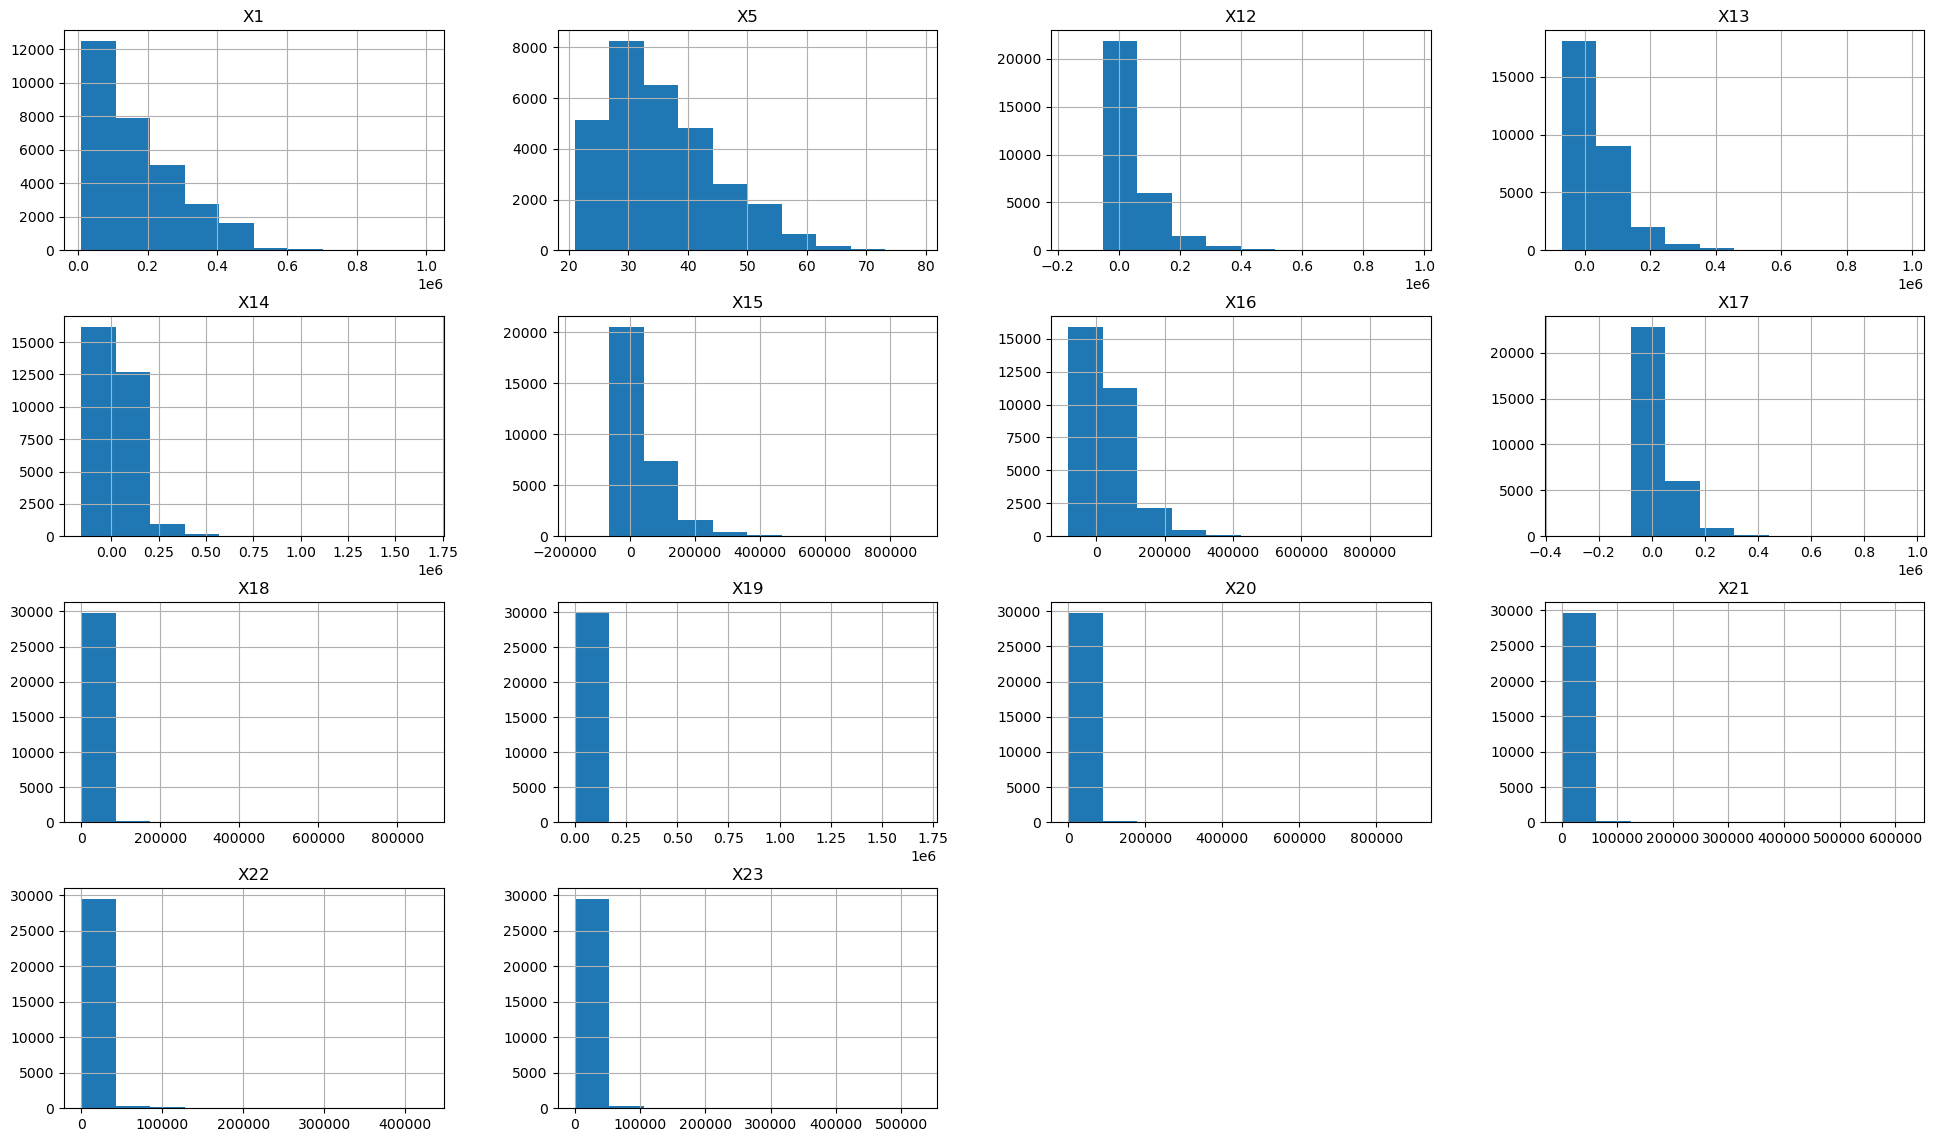

In [38]:
dataset.hist()
plt.show()

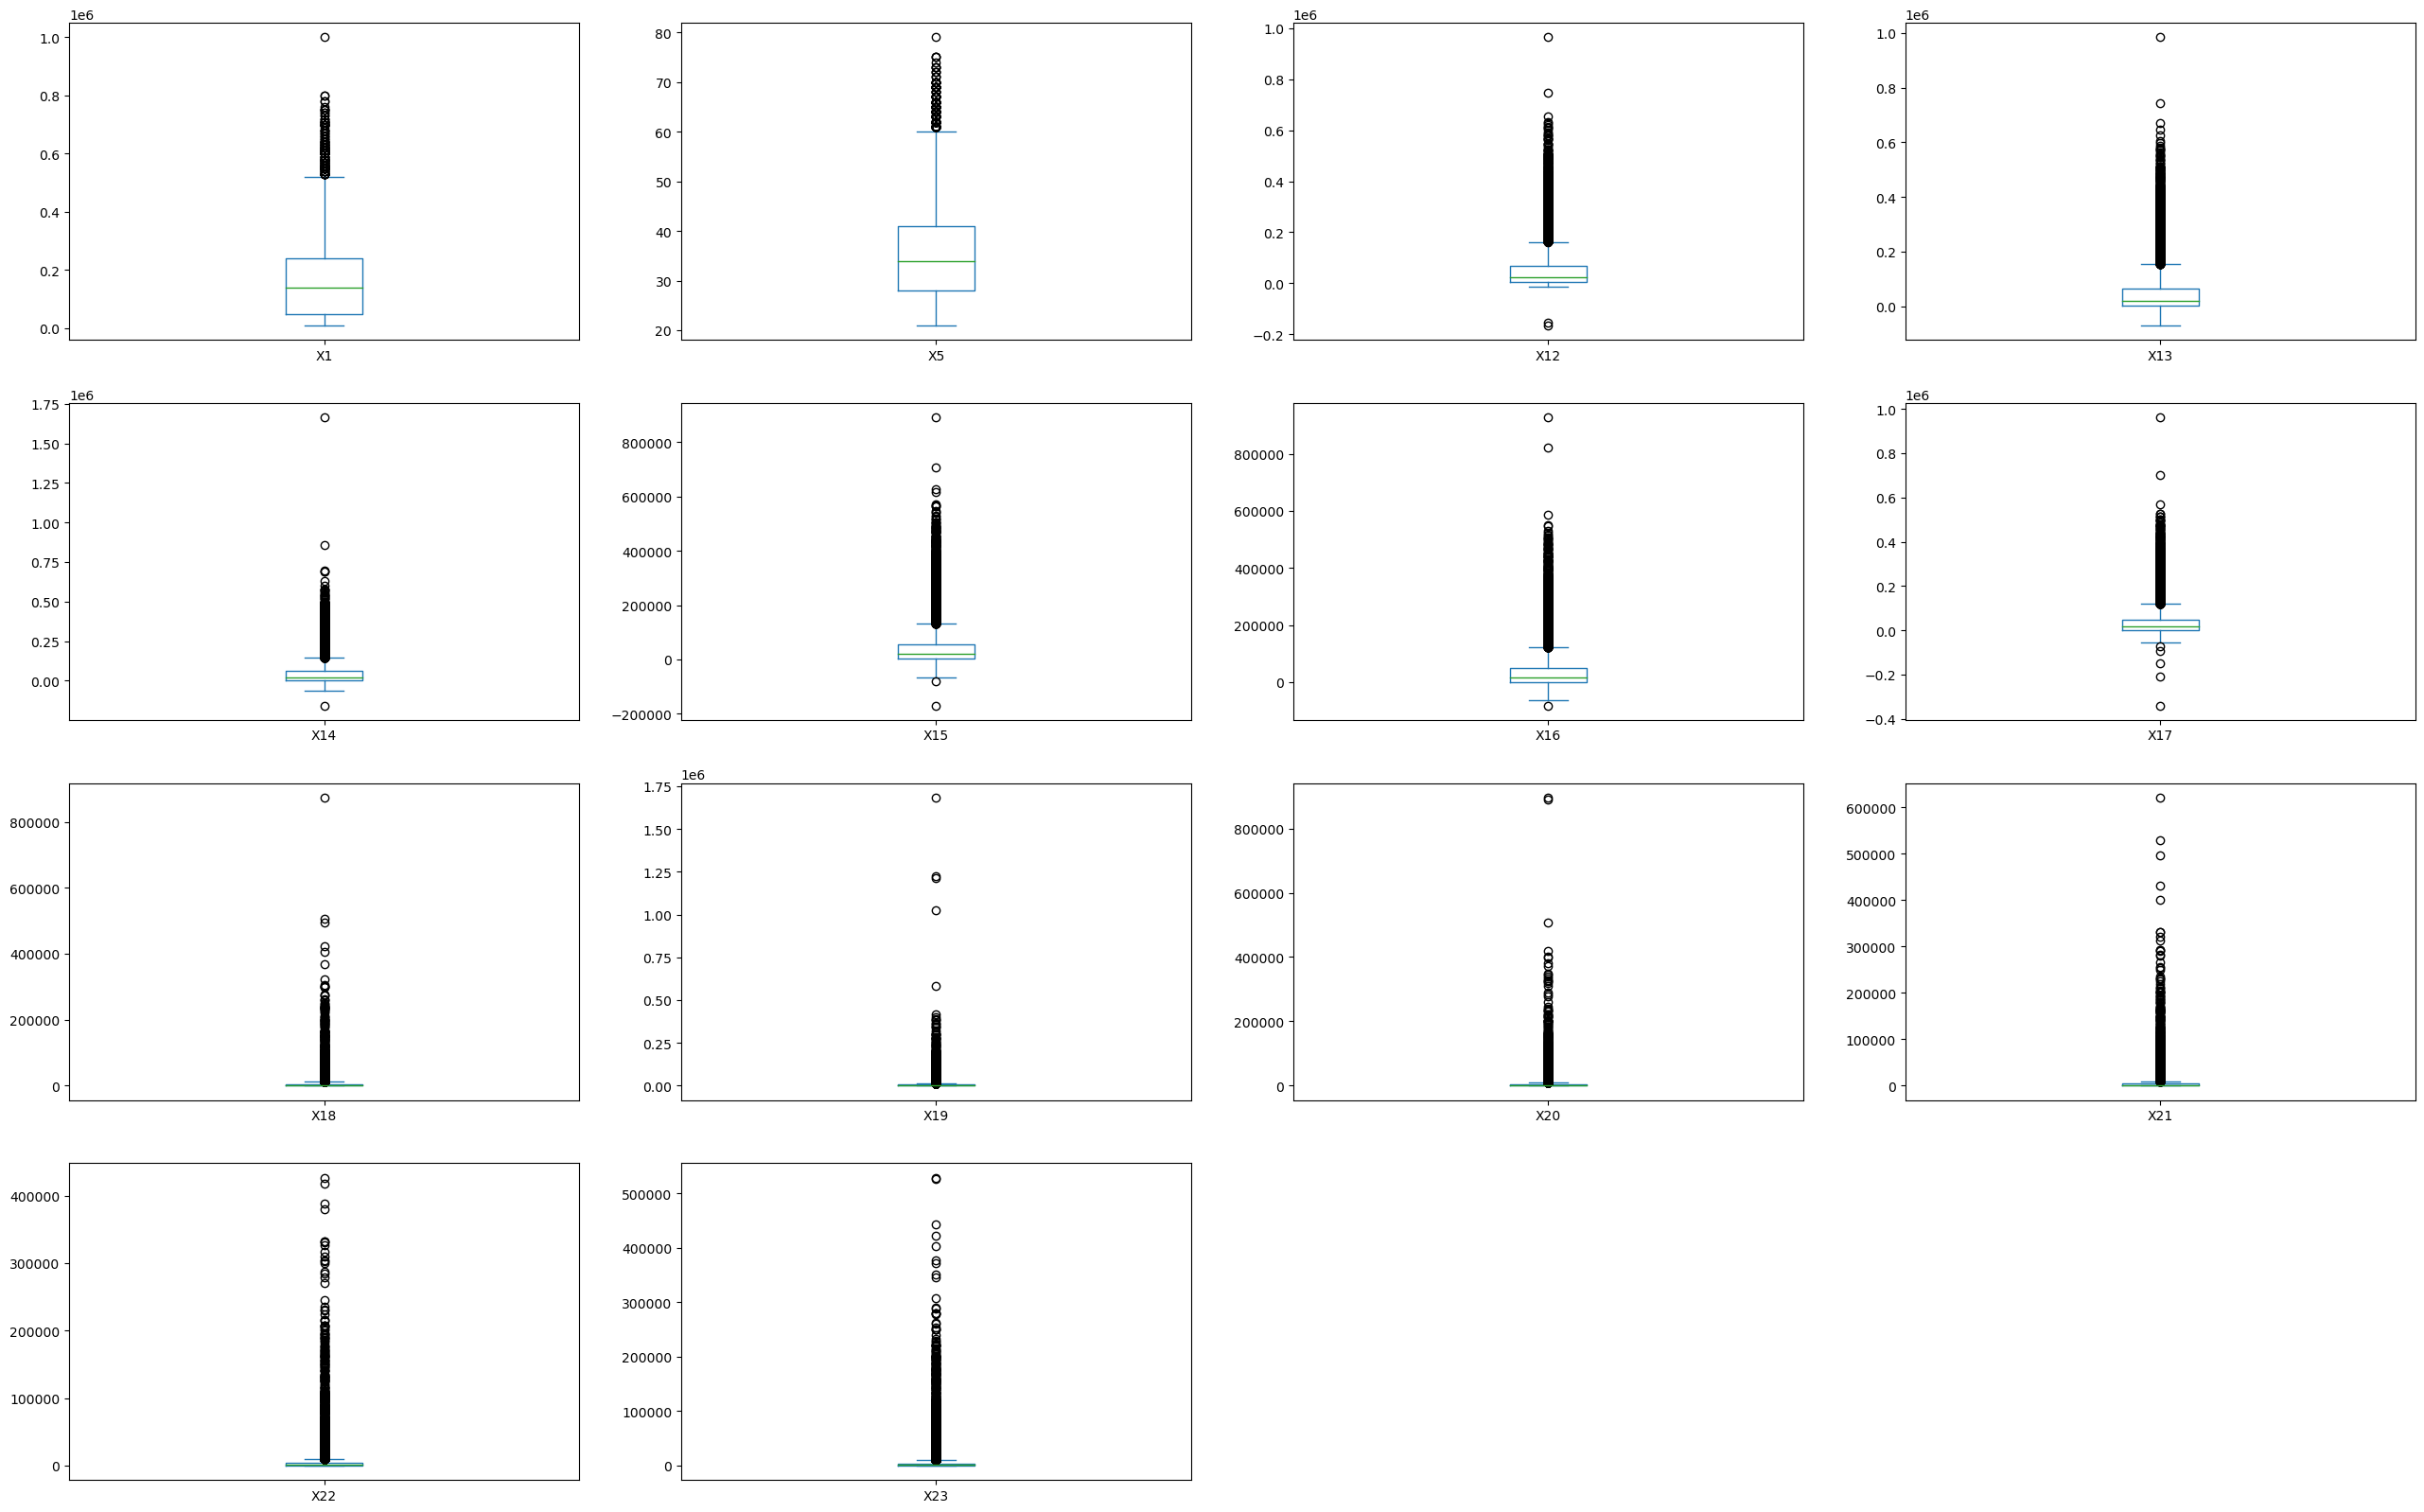

In [39]:
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(32,20))
plt.show()

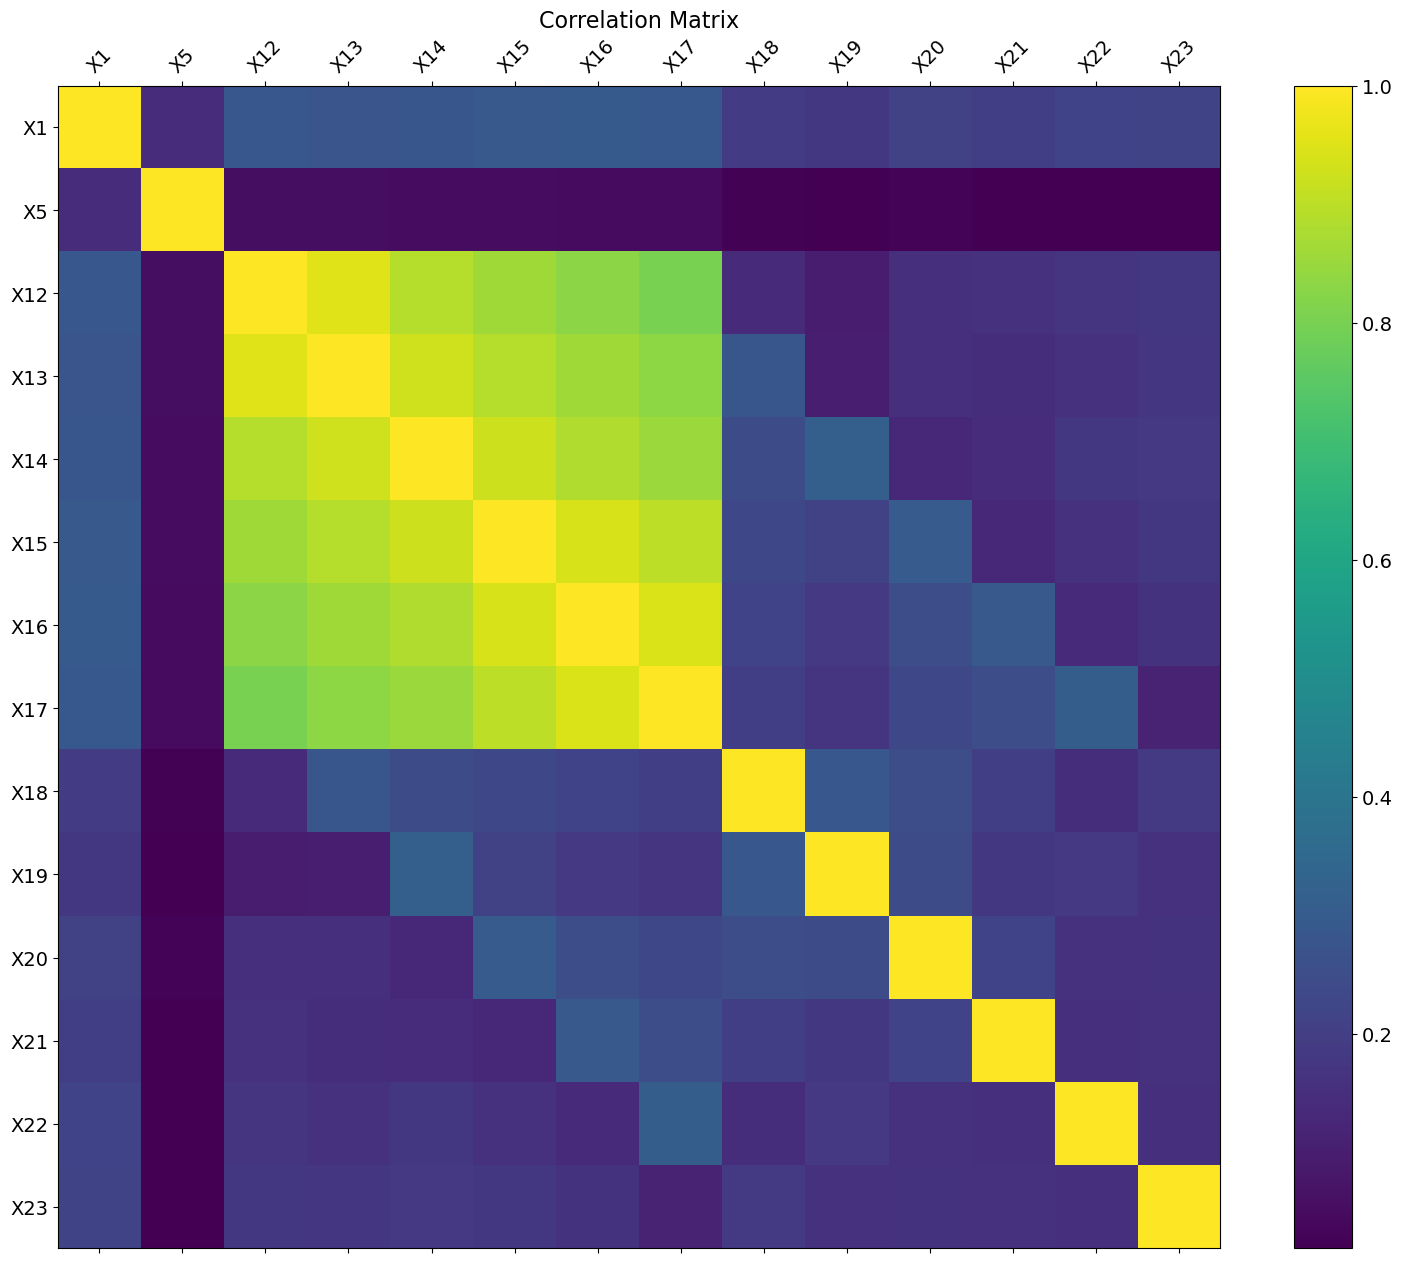

In [40]:
fig = plt.figure(figsize=(19, 15))
numeric_features = dataset.select_dtypes(['number'])
plt.matshow(numeric_features.corr(), fignum=fig.number)

plt.xticks(range(numeric_features.shape[1]), numeric_features.columns, fontsize=14, rotation=45)
plt.yticks(range(numeric_features.shape[1]), numeric_features.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

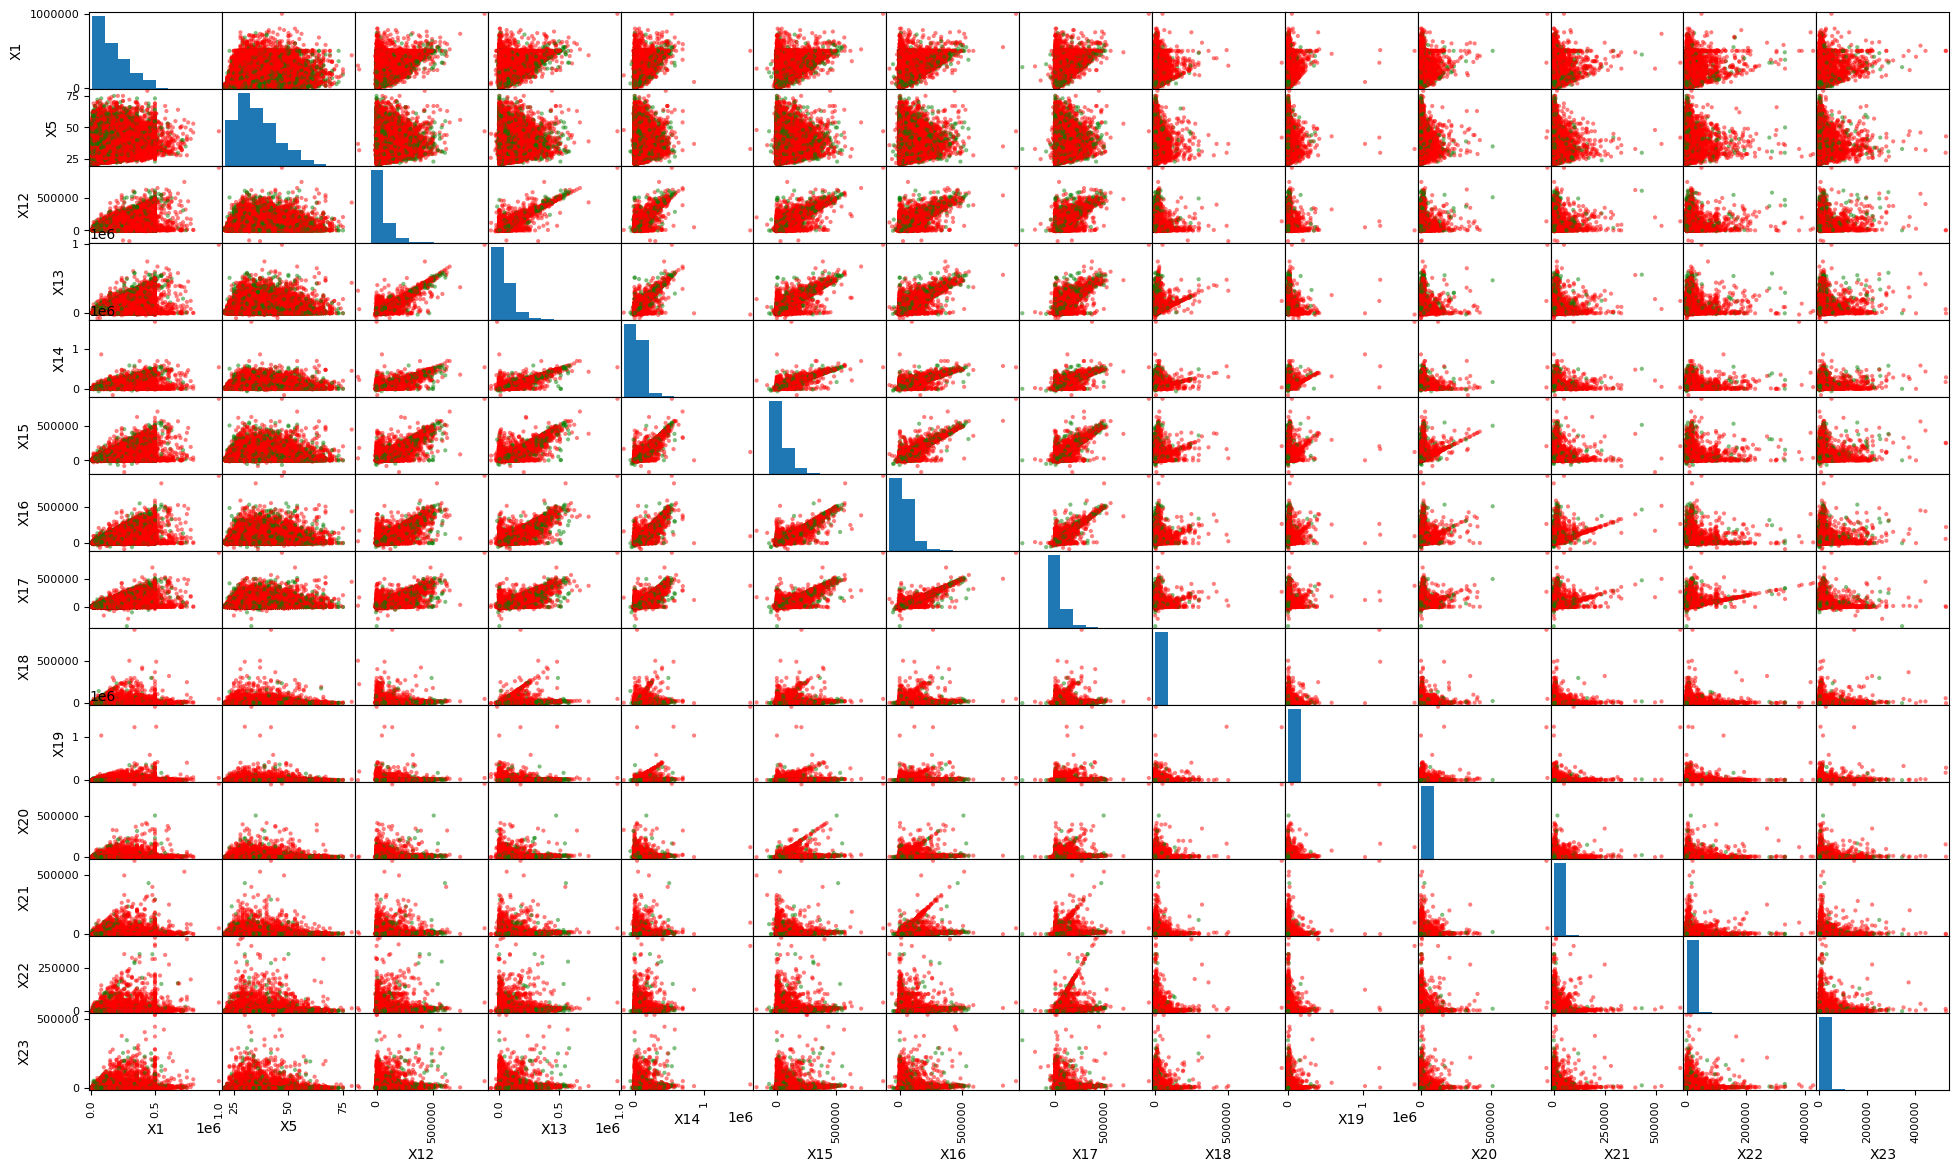

In [41]:
colors_palette = {0: 'red', 1: 'green'}
colors = [colors_palette[c] for c in dataset['Y']]
scatter_matrix(dataset, c=colors)
plt.show()

# Pre-processing

In [63]:
# Separa a base em teste e treino. A base de teste tem 25% do tamanho da base original
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=seed_value)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.25, random_state=seed_value)
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16875 entries, 16919 to 13253
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      16875 non-null  category
 1   X1      16875 non-null  float32 
 2   X2      16875 non-null  category
 3   X3      16875 non-null  category
 4   X4      16875 non-null  category
 5   X5      16875 non-null  int8    
 6   X6      16875 non-null  category
 7   X7      16875 non-null  category
 8   X8      16875 non-null  category
 9   X9      16875 non-null  category
 10  X10     16875 non-null  category
 11  X11     16875 non-null  category
 12  X12     16875 non-null  float32 
 13  X13     16875 non-null  float32 
 14  X14     16875 non-null  float32 
 15  X15     16875 non-null  float32 
 16  X16     16875 non-null  float32 
 17  X17     16875 non-null  float32 
 18  X18     16875 non-null  float32 
 19  X19     16875 non-null  float32 
 20  X20     16875 non-null  float32 
 21  X21     

In [80]:
# Separa as features
y_train = train_dataset['Y'].reset_index().drop('index', axis=1)
y_test = test_dataset['Y'].reset_index().drop('index', axis=1)
y_val = val_dataset['Y'].reset_index().drop('index', axis=1)

X_train = train_dataset.reset_index().drop(['index', 'Y'], axis=1)
X_test = test_dataset.reset_index().drop(['index', 'Y'], axis=1)
X_val = val_dataset.reset_index().drop(['index', 'Y'], axis=1)

In [81]:
# Oversampling
over_sampler = RandomOverSampler(random_state=seed_value)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
X_val, y_val = over_sampler.fit_resample(X_val, y_val)

print('Train\n',y_train.value_counts())
print('\nVal\n', y_val.value_counts())

Train
 Y
0    13111
1    13111
dtype: int64

Val
 Y
0    4378
1    4378
dtype: int64


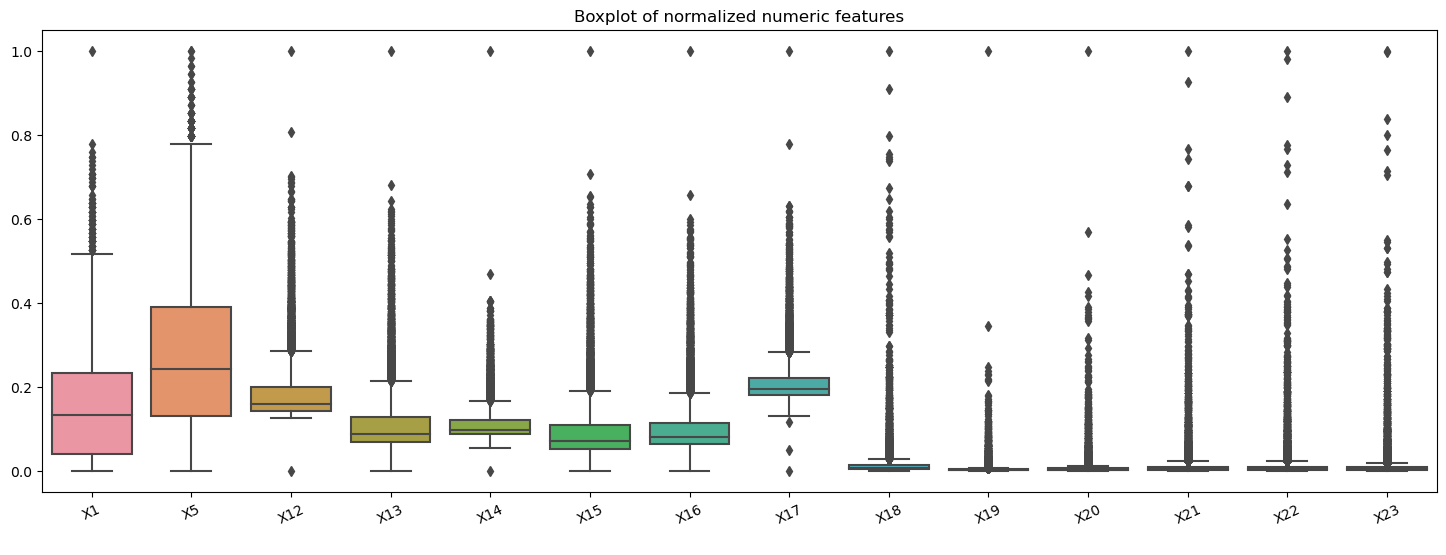

In [52]:
# Normaliza os dados numéricos usando MinMax
scaler = MinMaxScaler()

numeric_features = list(X_train.select_dtypes(['number']).columns)
X_train_normalized = X_train.copy()
X_val_normalized = X_val.copy()
X_test_normalized = X_test.copy()

# Remove a coluna ID
X_train_normalized.drop('ID', axis=1, inplace=True)
X_val_normalized.drop('ID', axis=1, inplace=True)
X_test_normalized.drop('ID', axis=1, inplace=True)

for f in numeric_features:
    X_train_normalized[f] = scaler.fit_transform(X_train[f].values.reshape(-1, 1))
    X_val_normalized[f] = scaler.fit_transform(X_val[f].values.reshape(-1, 1))
    X_test_normalized[f] = scaler.fit_transform(X_test[f].values.reshape(-1, 1))

sns.set_color_codes('deep')
fig, axs = plt.subplots(figsize=(18,6))

sns.boxplot(data=X_train_normalized[numeric_features])
axs.set_title('Boxplot of normalized numeric features')
axs.set_xticklabels(labels=numeric_features, rotation=25)
axs.set_xlabel(' ')

plt.show()

In [53]:
# Utiliza o One Hot Encoding nas features categoricas nominais
def one_hot_encoding(dataframe):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    x2_encodings = encoder.fit_transform(dataframe[['X2']])
    x2_dataset = pd.DataFrame(x2_encodings, columns=['X2_male', 'X2_female'])

    # x3_encodings = encoder.fit_transform(X_train_normalized[['X3']])
    # x3_dataset = pd.DataFrame(x3_encodings)

    x4_encodings = encoder.fit_transform(dataframe[['X4']])
    x4_dataset = pd.DataFrame(x4_encodings, columns=[0, 'X4_maried', 'X4_single', 'X4_others']).drop(0, axis=1)

    encoded_dataset = x2_dataset.join(x4_dataset)

    return dataframe.join(encoded_dataset).drop(['X2', 'X4'], axis=1)

X_train_normalized = one_hot_encoding(X_train_normalized)
X_val_normalized = one_hot_encoding(X_val_normalized)
X_test_normalized = one_hot_encoding(X_test_normalized)

X_train_normalized.head()

,X1,X3,X5,X6,X7,X8,X9,X10,X11,X12,...,X19,X20,X21,X22,X23,X2_male,X2_female,X4_maried,X4_single,X4_others
0,0.313131,1,0.555556,0,0,0,0,0,0,0.570046,...,0.007719,0.012455,0.019480,0.019518,0.016271,1.0,0.0,1.0,0.0,0.0
1,0.101010,2,0.222222,0,0,0,0,0,0,0.213255,...,0.002684,0.022320,0.006271,0.006565,0.005107,0.0,1.0,0.0,1.0,0.0
2,0.040404,3,0.074074,1,-1,0,0,0,0,0.137397,...,0.001787,0.001116,0.000743,0.004689,0.001892,0.0,1.0,1.0,0.0,0.0
3,0.101010,2,0.555556,-2,-2,-2,-1,-1,-1,0.272423,...,0.000000,0.003356,0.001983,0.234451,0.001892,0.0,1.0,0.0,1.0,0.0
4,0.353535,2,0.481481,-2,-2,-2,-2,-2,-2,0.139978,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0


In [54]:
# Utiliza o Ordinal Encoding nas features categoricas ordinais
def ordinal_encoding(dataframe):
    encoder = OrdinalEncoder()
    pay_features = [f'X{i}' for i in range(6, 12)]

    dataframe['X3'] = encoder.fit_transform(dataframe[['X3']])
    dataframe[pay_features] = encoder.fit_transform(dataframe[pay_features])

    return dataframe

X_train_normalized = ordinal_encoding(X_train_normalized)
X_val_normalized = ordinal_encoding(X_val_normalized)
X_test_normalized = ordinal_encoding(X_test_normalized)

X_train_normalized.head()

,X1,X3,X5,X6,X7,X8,X9,X10,X11,X12,...,X19,X20,X21,X22,X23,X2_male,X2_female,X4_maried,X4_single,X4_others
0,0.313131,1.0,0.555556,2.0,2.0,2.0,2.0,2.0,2.0,0.570046,...,0.007719,0.012455,0.019480,0.019518,0.016271,1.0,0.0,1.0,0.0,0.0
1,0.101010,2.0,0.222222,2.0,2.0,2.0,2.0,2.0,2.0,0.213255,...,0.002684,0.022320,0.006271,0.006565,0.005107,0.0,1.0,0.0,1.0,0.0
2,0.040404,3.0,0.074074,3.0,1.0,2.0,2.0,2.0,2.0,0.137397,...,0.001787,0.001116,0.000743,0.004689,0.001892,0.0,1.0,1.0,0.0,0.0
3,0.101010,2.0,0.555556,0.0,0.0,0.0,1.0,1.0,1.0,0.272423,...,0.000000,0.003356,0.001983,0.234451,0.001892,0.0,1.0,0.0,1.0,0.0
4,0.353535,2.0,0.481481,0.0,0.0,0.0,0.0,0.0,0.0,0.139978,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0


In [19]:
# Salva em um arquivo
# X_train_normalized.to_csv('./train_dataset.csv')
# X_val_normalized.to_csv('./validation_dataset')

# files.download('./train_dataset.csv')
# files.download('./validation_dataset.csv')

# Modelos

define o k-fold

In [21]:
cv = StratifiedKFold(n_splits=10)

## Support Vector Machine (SVM)

In [22]:
from sklearn.svm import SVC

params = {
    'C': [0.1, 1, 2, 5, 10, 20, 50, 100, 500, 1000],
    'kernel': ['rbf', 'sigmoid'], # 'poly'],
    'gamma': [0.01, 0.1, 1, 2, 5, 10, 20, 50, 100]
}

svc = SVC()
search = RandomizedSearchCV(svc, params, n_iter=10, scoring='accuracy', n_jobs=4, cv=cv, random_state=seed_value)

# execute search
result_svc = search.fit(X_train_normalized.values, y_train.values)
svm_model = result_svc.best_estimator_

# summarize result for SVM
print('========= Random Search Results for SVM ==========')
print('Best Score: %s' % result_svc.best_score_)
print('Best Hyperparameters: %s' % result_svc.best_params_)

========= Random Search Results for SVM ==========
Best Score: 0.7884440044724503
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 1, 'C': 50}


## Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier()

space = {
  'criterion': ['gini', 'entropy', 'log_loss'],
  'splitter': ["best", "random"],
  'min_samples_split': [2,3,5,7],
  'max_depth': [3,5,6,7,9,11,13,15,17,19],
  'min_samples_leaf': [2, 3]
}

search = RandomizedSearchCV(decisionTree, space, n_iter=50, scoring='accuracy', n_jobs=4, cv=cv)
result_tree = search.fit(X_train, y_train)
decision_tree_model = result_svc.best_estimator_

print('=========Random Search Results fro TREE==========')
print('Best Score: %s' % result_tree.best_score_)
print('Best Hyperparameters: %s' % result_tree.best_params_)

# Random Forest

In [ ]:
# Random Forest Classification
import pandas
from sklearn import tree
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

#semente de numeros aleatorios
seed = 7
num_trees = 15
max_features = 6
criterion = ['gini', 'entropy', 'log_loss']

#numero de folds atraves do metodo k-fold
kfold = model_selection.StratifiedKFold(n_splits=10)

#criando o classificador Random Forest
model_rf = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, random_state=seed)

#treinamento do Random Forest em dez folds
results = model_selection.cross_val_score(model_rf, X_train_normalized, y_train.values.ravel(), cv=kfold)

model_rf = model_rf.fit(X_train_normalized, y_train.values.ravel())

print("Random Forest folds:", results, "\nMedia treinamento:", results.mean())
print("Treinamento: ", model_rf.score(X_train_normalized, y_train))
print("Teste: ", model_rf.score(X_val_normalized, y_val))

Random Forest folds: [0.81398104 0.80035545 0.80450237 0.80864929 0.8056872  0.81979846
 0.79253112 0.7984588  0.80735033 0.7966805 ] 
Media treinamento: 0.8047994561140811
Treinamento:  0.992237037037037
Teste:  0.6401777777777777
